Compare to [R solution](https://github.com/WinVector/PDSwR2/blob/master/KDD2009/KDD2009vtreat.md).

First read in data

In [1]:
import pandas

dir = "../../PracticalDataScienceWithR2nd/PDSwR2/KDD2009/"
d = pandas.read_csv(dir + 'orange_small_train.data.gz', sep='\t', header=0)
vars = [c for c in d.columns]
d.shape

(50000, 230)

In [2]:
churn = pandas.read_csv(dir + 'orange_small_train_churn.labels.txt', header=None)
churn.columns = ["churn"]
churn.shape

(50000, 1)

In [3]:
churn["churn"].value_counts()

-1    46328
 1     3672
Name: churn, dtype: int64

arrange test/train split

In [4]:
import numpy.random

n = d.shape[0]
is_train = numpy.random.uniform(size=n)<=0.9
is_test = numpy.logical_not(is_train)

In [5]:
d_train = d.loc[is_train, :].copy()
churn_train = numpy.asarray(churn.loc[is_train, :]["churn"]==1)
d_test = d.loc[is_test, :].copy()
churn_test = numpy.asarray(churn.loc[is_test, :]["churn"]==1)

Treat variables

In [6]:
import vtreat

In [7]:
plan = vtreat.binomial_outcome_treatment(outcomename="y", outcometarget=True)

In [8]:
cross_frame = plan.fit_transform(d_train, churn_train)

In [9]:
sf = plan.score_frame_
sf.head()

,variable,treatment,y_aware,PearsonR,significance,vcount,recommended
0,Var1_is_bad,missing_indicator,False,0.002940,0.532821,193.0,False
1,Var2_is_bad,missing_indicator,False,0.017924,0.000143,193.0,True
2,Var3_is_bad,missing_indicator,False,0.017892,0.000147,193.0,True
3,Var4_is_bad,missing_indicator,False,0.019381,0.000039,193.0,True
4,Var5_is_bad,missing_indicator,False,0.017084,0.000290,193.0,True


In [10]:
sf.shape

(519, 7)

In [11]:
sf.loc[numpy.logical_and(sf["recommended"],sf["y_aware"]), :]

,variable,treatment,y_aware,PearsonR,significance,vcount,recommended


In [12]:
model_vars = numpy.asarray(sf["variable"][sf["recommended"]])
len(model_vars)

231

In [13]:
cross_frame.head()

,Var1_is_bad,Var2_is_bad,Var3_is_bad,Var4_is_bad,Var5_is_bad,Var6_is_bad,Var7_is_bad,Var9_is_bad,Var10_is_bad,Var11_is_bad,...,Var228_logit_code,Var228_prevalence_code,Var228_lev_F2FyR07IdsN7I,Var228_lev_55YFVY9,Var228_lev_ib5G6X1eUxUn6,Var229_logit_code,Var229_prevalence_code,Var229_lev__NA_,Var229_lev_am7c,Var229_lev_mj86
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,-0.042224,0.653350,1,0,0,-0.013249,0.567381,1,0,0
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,-0.005247,0.053816,0,0,1,-0.013249,0.234463,0,1,0
2,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,-0.099267,0.653350,1,0,0,-0.004138,0.567381,1,0,0
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,-0.004067,0.653350,1,0,0,0.010131,0.196534,0,0,1
4,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,-0.001372,0.018642,0,0,0,0.046218,0.234463,0,1,0


In [14]:
import xgboost

In [15]:

fd = xgboost.DMatrix(data=cross_frame.loc[:, model_vars], label=churn_train)
x_parameters = {"max_depth":3, "objective":'binary:logistic'}
cv = xgboost.cv(x_parameters, fd, num_boost_round=100, verbose_eval=False)

In [16]:
cv.head()

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.072581,0.000896,0.072925,0.001414
1,0.072803,0.000740,0.072903,0.001523
2,0.072858,0.000777,0.072836,0.001523
3,0.072858,0.000777,0.072836,0.001523
4,0.072858,0.000777,0.072859,0.001555


In [17]:
best = cv.loc[cv["test-error-mean"]<= min(cv["test-error-mean"] + 1.0e-9), :]
best



,train-error-mean,train-error-std,test-error-mean,test-error-std
18,0.072314,0.00070,0.072481,0.001588
23,0.072103,0.00086,0.072481,0.001445


In [18]:
ntree = best.index.values[0]
ntree

18

In [19]:
fitter = xgboost.XGBClassifier(n_estimators=ntree, max_depth=3, objective='binary:logistic')
fitter

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=18,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [20]:
model = fitter.fit(cross_frame.loc[:, model_vars], churn_train)




In [21]:
test_processed = plan.transform(d_test)

In [22]:

pf = pandas.DataFrame({"churn":churn_test})
preds = model.predict_proba(test_processed.loc[:, model_vars])



In [23]:
pf["pred"] = preds[:, 1]

In [24]:
import wvpy.util

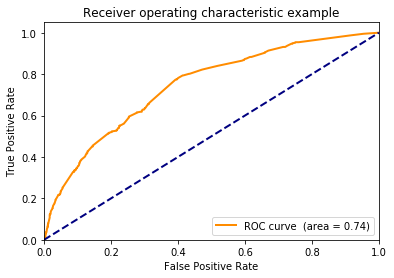

0.7435477218114039

In [25]:
wvpy.util.plot_roc(pf["pred"], pf["churn"])